
## 1. Entendimiento del Negocio
### Objetivos:

- Predecir el precio de cierre (Close) del US Dollar Index (DXY).

- Predecir el porcentaje de cambio diario (Change %).

- Identificar momentos óptimos para comprar/vender basados en predicciones.

## 2. Entendimiento de los Datos

Carguemos y exploremos el dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5623 entries, 0 to 5622
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5623 non-null   datetime64[ns]
 1   Price     5623 non-null   float64       
 2   Open      5623 non-null   float64       
 3   High      5623 non-null   float64       
 4   Low       5623 non-null   float64       
 5   Change %  5623 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 263.7+ KB
None
                                Date        Price         Open         High  \
count                           5623  5623.000000  5623.000000  5623.000000   
mean   2011-12-03 08:26:17.520896256    90.503363    90.501930    90.825543   
min              2001-01-02 00:00:00    71.330000    71.330000    71.690000   
25%              2006-07-06 12:00:00    81.440000    81.430000    81.720000   
50%              2011-12-15 00:00:00    89.990000    

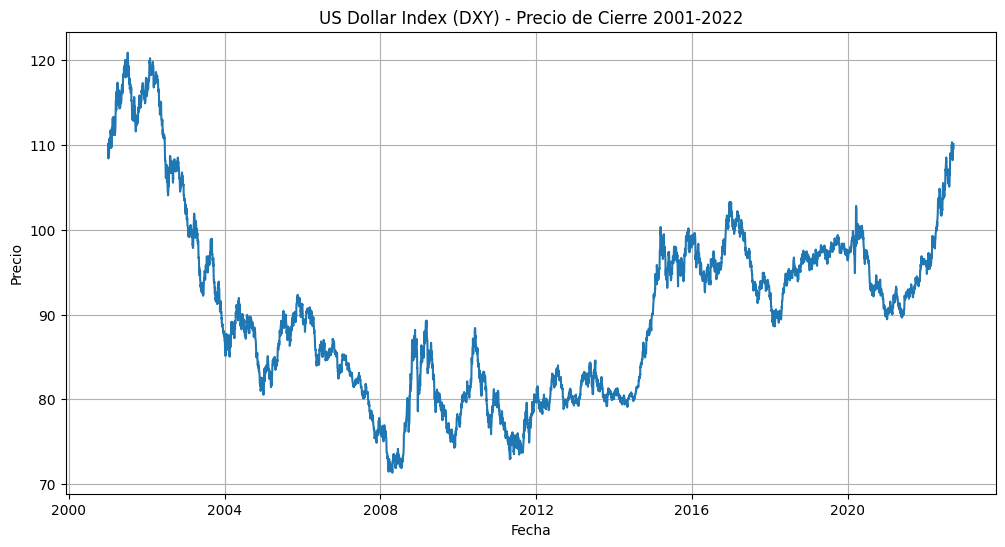

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Cargar datos
df = pd.read_csv('US Dollar Index Historical Data.csv', parse_dates=['Date'])
df.head()

# Verificar datos nulos y tipos
print(df.info())
print(df.describe())

# Visualizar serie temporal
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='Close Price')
plt.title('US Dollar Index (DXY) - Precio de Cierre 2001-2022')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid()
plt.show()

## 3. Preparación de los Datos

### Features:

- Usaremos Open, High, Low, y medias móviles para predecir Price (Close).

- Para el Change %, calcularemos la variación diaria si no está en los datos.

In [2]:
# Limpieza: Eliminar filas con NaN y convertir 'Change %' a numérico
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Crear features
df['MA_7'] = df['Price'].rolling(window=7).mean()  # Media móvil 7 días
df['MA_30'] = df['Price'].rolling(window=30).mean()  # Media móvil 30 días
df['Volatility'] = df['High'] - df['Low']  # Volatilidad diaria

# Eliminar filas con NaN (por medias móviles)
df = df.dropna()

# Definir variables
X = df[['Open', 'High', 'Low', 'MA_7', 'MA_30', 'Volatility']]
y_price = df['Price']  # Target para precio
y_change = df['Change %']  # Target para cambio %

# Split en train/test (80/20)
X_train, X_test, y_price_train, y_price_test = train_test_split(X, y_price, test_size=0.2, random_state=42)
_, _, y_change_train, y_change_test = train_test_split(X, y_change, test_size=0.2, random_state=42)

## 4. Modelado

### A. Modelado para precio de Cierre

In [4]:
# Modelo de regresión lineal
model_price = LinearRegression()
model_price.fit(X_train, y_price_train)

# Predicciones
y_price_pred = model_price.predict(X_test)

# Evaluación
rmse_price = np.sqrt(mean_squared_error(y_price_test, y_price_pred))
r2_price = r2_score(y_price_test, y_price_pred)
print(f'RMSE (Price): {rmse_price:.2f}')
print(f'R² (Price): {r2_price:.2f}')

RMSE (Price): 0.17
R² (Price): 1.00


### B. Modelado para Cambio Porcentual

In [6]:
model_change = LinearRegression()
model_change.fit(X_train, y_change_train)

y_change_pred = model_change.predict(X_test)

rmse_change = np.sqrt(mean_squared_error(y_change_test, y_change_pred))
r2_change = r2_score(y_change_test, y_change_pred)
print(f'RMSE (Change %): {rmse_change:.2f}')
print(f'R² (Change %): {r2_change:.2f}')

RMSE (Change %): 0.26
R² (Change %): 0.72


## 5. Evaluación

### Visualización de resultados

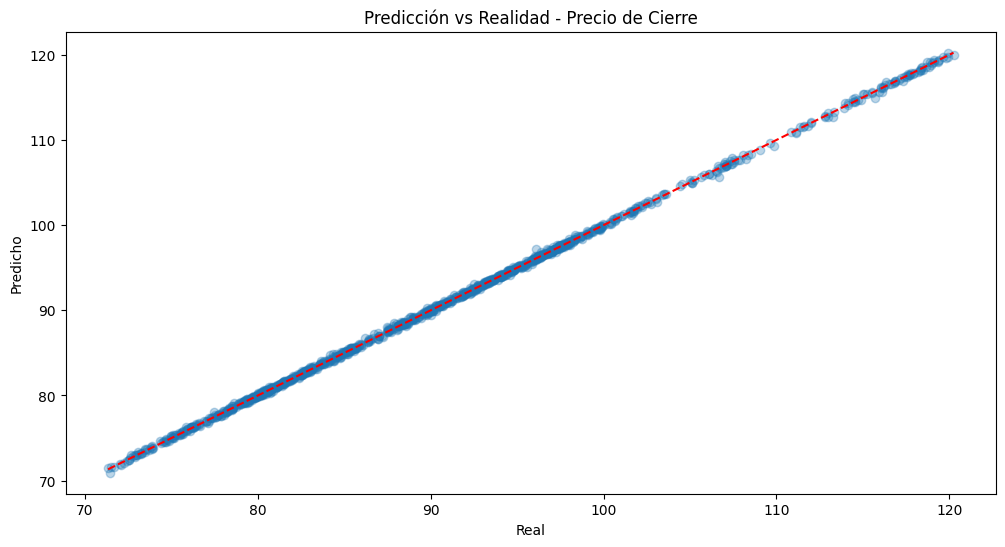

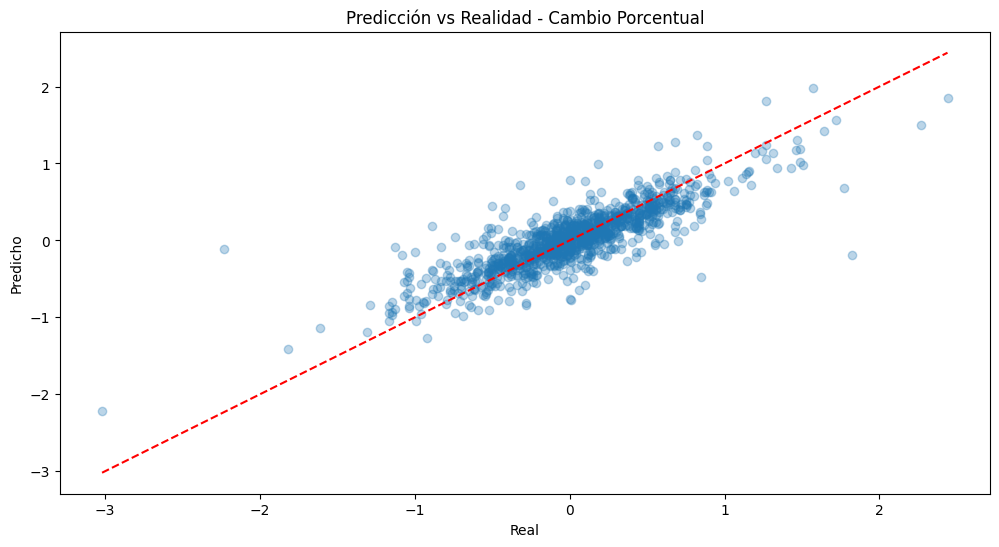

In [7]:
# Gráfico de predicciones vs. realidad (Price)
plt.figure(figsize=(12, 6))
plt.scatter(y_price_test, y_price_pred, alpha=0.3)
plt.plot([min(y_price_test), max(y_price_test)], [min(y_price_test), max(y_price_test)], 'r--')
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Predicción vs Realidad - Precio de Cierre')
plt.show()

# Gráfico de predicciones vs. realidad (Change %)
plt.figure(figsize=(12, 6))
plt.scatter(y_change_test, y_change_pred, alpha=0.3)
plt.plot([min(y_change_test), max(y_change_test)], [min(y_change_test), max(y_change_test)], 'r--')
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Predicción vs Realidad - Cambio Porcentual')
plt.show()

## 6. Despliegue - Estrategia de Compra Venta

### Regla simple

- *Comprar:* Si el Change % predicho es positivo y mayor que un umbral

- *Vender:* Si el Change % predicho es negativo

In [8]:
# Aplicar estrategia al conjunto de prueba
df_test = X_test.copy()
df_test['Pred_Change %'] = y_change_pred
df_test['Action'] = np.where(df_test['Pred_Change %'] > 0.5, 'Buy', 'Hold')
df_test['Action'] = np.where(df_test['Pred_Change %'] < -0.5, 'Sell', df_test['Action'])

# Mostrar acciones recomendadas
print(df_test[['Open', 'High', 'Low', 'Pred_Change %', 'Action']].head(10))

        Open    High     Low  Pred_Change % Action
1994   86.32   87.86   86.04       1.223323    Buy
2480   82.91   82.92   82.38      -0.427247   Hold
3504   81.46   81.68   81.47       0.206491   Hold
2380   81.12   81.33   80.96       0.071512   Hold
325   117.48  117.79  117.39       0.158078   Hold
4955   97.56   97.69   96.98      -0.456050   Hold
3675   97.86   98.20   97.25      -0.224205   Hold
1755   75.76   75.91   75.06      -0.478578   Hold
1587   83.39   83.46   82.94      -0.316040   Hold
482   105.74  106.08  105.58       0.164307   Hold
